In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Wrapper class for scalar values, that will give us basic mathematical operations with information about what values created them with what operation. Which will basically allow us to create a graph of operations and then calculate gradients of the graph.

In [2]:
class Value:
    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.children = set(children)
        self.operation = operation
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, children={self.children}, op='{self.operation}')"
    
    def __add__(self, other):
            return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
            return Value(self.data * other.data, (self, other), '*')
    

In [13]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
out = d+c; out.label = 'out' # out = a*b+c

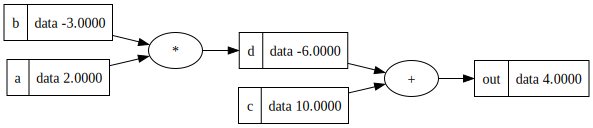

In [14]:
from ipynb.fs.full.draw import draw_dot

draw_dot(out)